https://towardsdatascience.com/differentiable-programming-from-scratch-abba0ebebc1c

https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6

https://towardsdatascience.com/automatic-differentiation-explained-b4ba8e60c2ad

# Automatic Differentiation

In [1]:
from __future__ import division

class DualFloat:
    def __init__(self, x=0, x_p=0):
        self.x = x
        self.x_p = x_p

    def __str__(self):
        return "DF({0}, {1})".format(self.x, self.x_p)

    def convert(self, x):
        if isinstance(x, int) or isinstance(x, float):
            return DualFloat(x, 0.0)
        elif isinstance(x, DualFloat):
            return x
        raise Exception(f"Type {type(x)} not supported")

    def __add__(self, other):
        other = self.convert(other)
        x = self.x + other.x
        x_p = self.x_p + other.x_p
        return DualFloat(x, x_p)

    def __sub__(self, other):
        other = self.convert(other)
        x = self.x - other.x
        x_p = self.x_p - other.x_p
        return DualFloat(x, x_p)

    def __mul__(self, other):
        other = self.convert(other)
        x = self.x * other.x
        x_p = self.x_p * other.x + self.x * other.x_p
        return DualFloat(x, x_p)

    def __truediv__(self, other):
        other = self.convert(other)
        x = self.x / other.x
        x_p = (self.x_p * other.x - self.x * other.x_p) / other.x**2
        return DualFloat(x, x_p)

    def __pow__(self, other):
        if not (isinstance(other, int) or isinstance(other, float)):
            raise Exception(f"Type {type(x)} not supported")
        x = self.x**other
        x_p = other * self.x_p * self.x**(other-1)
        return DualFloat(x, x_p)

    def __float__(self):
        return float(self.x)

    def value(self):
        return self.x

    def derivative(self):
        return self.x_p

In [2]:
def simple_polynome(a, b):
    return lambda x : x**2 * a + b

def squared_polynome(a, b, c):
    return lambda x : x**2 * a + x * b + c

def squared_polynome_check(a, b, c):
    return lambda x : 2*x * a + b

f1 = simple_polynome(3.0, 0.0)
f2 = squared_polynome(3.0, 2.0, 1.0)
f3 = squared_polynome_check(3.0, 2.0, 1.0)

r = f1(DualFloat(4, 1.0))
print(r)

r = f2(DualFloat(3, 1.0))
check = f3(3)

print(r.derivative())
print(check)


DF(48.0, 24.0)
20.0
20.0


In [3]:
def simple_fraction(a, b):
    return lambda x : DualFloat(a, 0)/x**2 + b

f1 = simple_fraction(1.0, 0.0)
r = f1(DualFloat(4.0, 1.0))
print(r)

DF(0.0625, -0.03125)


## Using Gradient Descent and Automatic Differentiation to find  $x$ where  $y = -3 $ and  $y =2x^{2} + x -3$ 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

f2 = squared_polynome(2.0, 1.0, -3.0)
y_true = DualFloat(-2.1)

def polynome(x):
    return f2(x)

def errors(value):
    y_pred = polynome(value)
    return y_true - y_pred

x_avg = DualFloat(0.3, 1.0)
for i in range(0,1000):
    error = errors(x_avg)**2
    diff = error.derivative()
    x_avg = x_avg - diff * 0.05
print('new avg: ', x_avg)

new avg:  DF(0.4658910531638176, 1.0)


# Quantum Differentiable Programming (QDP)

## Using Gradient Descent and Quantum Automatic Differentiation to find  $x$ where  $y = -2.1 $ and  $y =2x^{2} + x -3$ 

## Shift rule:
## <center>$\frac{\partial}{\partial \theta} f(\theta) = \frac{f(\theta + s) - f(\theta - s)}{2 \sin(s)}$</center>

https://pennylane.ai/qml/glossary/parameter_shift.html

In [5]:
from QVM.qvm_circuit import *
from QVM.qvm_gate import *
import random

In [6]:
def polynome(state, prob):
    x = (2*int(state[0])-1)*prob[0]/2 + (2*int(state[1])-1)*prob[1]/2
#     return 2*x**2 + x -3
    return np.sin(x)- x**2

def errors(y_true, state, prob):
    y_pred = polynome(state, prob)
    return abs(y_true - y_pred)**2

def random_float(low, high):
    return random.random()*(high-low) + low

In [7]:
y_true = -0.2
phi = random_float(0.1, np.pi-0.2)
n = 1

c = Qubit(n)
RY(c, 0, phi)

result = polynome(c.state, c.probabilities())
m = 0

while abs(result - y_true) > 1e-3:
    c1 = Qubit(n)
    c2 = Qubit(n)

    RY(c1, 0, phi+np.pi/20)
    RY(c2, 0, phi-np.pi/20)

    diff = (errors(y_true, c1.state, c1.probabilities())-errors(y_true, c2.state, c2.probabilities()))/(2*np.sin(np.pi/20))
    phi = phi - diff * 1e+13%(2*np.pi)

    c = Qubit(n)
    RY(c, 0, phi)
    result = polynome(c.state, c.probabilities())
    state = c.state
    prob = c.probabilities()
    m += 1

print('new result: ',result, 
      (2*int(state[0])-1)*prob[0]/2 + (2*int(state[1])-1)*prob[1]/2, m)

new result:  -0.19981336127741667 -0.1713046728024486 2921


In [8]:
# for j in np.linspace(0.1, np.pi-0.2):
#     phi = j
#     y_true = -2.3
#     n = 1

#     c = Qubit(n)
#     RY(c, 0, phi)

#     result = polynome(c.state, c.probabilities())
#     m = 0

#     while abs(result - y_true) > 1e-3:
# #     for i in range(10000):
#         c_1 = Qubit(n)
#         c_2 = Qubit(n)

#         RY(c_1, 0, phi+np.pi/20)
#         RY(c_2, 0, phi-np.pi/20)

#         diff = (errors(y_true, c_1.state, c_1.probabilities())-errors(y_true, c_2.state, c_2.probabilities()))/(2*np.pi/20)

#         phi = phi - diff * 1e+13

#         c = Qubit(n)
#         RY(c, 0, phi)
#         result = polynome(c.state, c.probabilities())
#         state = c.state
#         prob = c.probabilities()
#         m += 1
# #         if abs(result - y_true) < 1e-3:
# #             break

#     print('new result: ',result, 
#           (2*int(state[0])-1)*prob[0]/2 + (2*int(state[1])-1)*prob[1]/2, j/np.pi, m)

In [9]:
# for j in np.linspace(0.1, np.pi-0.2):
#     phi = j
#     y_true = -2.3
#     n = 1

#     c = Qubit(n)
#     RY(c, 0, phi)

#     result = polynome(c.state, c.probabilities())
#     m = 0

#     while abs(result - y_true) > 1e-3:
# #     for i in range(10000):
#         c_1 = Qubit(n)
#         c_2 = Qubit(n)

#         RY(c_1, 0, phi+np.pi/20)
#         RY(c_2, 0, phi-np.pi/20)

#         diff = (errors(y_true, c_1.state, c_1.probabilities())-errors(y_true, c_2.state, c_2.probabilities()))/(2*np.sin(np.pi/20))

#         phi = phi - diff * 1e+13

#         c = Qubit(n)
#         RY(c, 0, phi)
#         result = polynome(c.state, c.probabilities())
#         state = c.state
#         prob = c.probabilities()
#         m += 1
# #         if abs(result - y_true) < 1e-3:
# #             break

#     print('new result: ',result, 
#           (2*int(state[0])-1)*prob[0]/2 + (2*int(state[1])-1)*prob[1]/2, j/np.pi, m)

## Ising model 

Caculate expectataion energy of Hamiltonian

$ <E> = \sum_{z} P(z) E(z) $ for $ z \in \{ 0, 1 \}^{n} $

$ E = - J\sum_{i}^{n-1} s^{z}_{i} s^{z}_{i+1} - h\sum_{i}^{n} s^{z}_{i} $ 
with $ s^{z}_{i} = 1 $ for $ z_{i} = 0 $ and $ s^{z}_{i} = - 1 $ for $ z_{i} = 1 $

In [10]:
def energy(state, h, J):
    # (x-0.5)*2 map [0, 1] to [1, -1]
    energy = 2*h*(int(state[-1])-0.5)
    for i in range(len(state)-1):
        energy += J*(int(state[i])-0.5)*(int(state[i+1])-0.5)*4 + 2*h*(int(state[i])-0.5)
    return -energy

def expectation_energy(wavefunction, h, J):

    states = wavefunction.state
    prob = wavefunction.probabilities()
    expect = 0
    for i in range(len(states)):
        expect += prob[i]*energy(states[i], h, J)
    return expect

https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [11]:
def ising_circuit(phi_1, phi_2):
    '''Linear Entanglement, deep = 1'''
    c = Qubit(4)

    RY(c, 0, phi_1[0])
    RY(c, 1, phi_1[1])
    RY(c, 2, phi_1[2])
    RY(c, 3, phi_1[3])

    RZ(c, 0, phi_2[0])
    RZ(c, 1, phi_2[1])
    RZ(c, 2, phi_2[2])
    RZ(c, 3, phi_2[3])

    CNOT(c, 0, 1)
    CNOT(c, 1, 2)
    CNOT(c, 2, 3)
    
    return c

In [12]:
def errors(y_true, wavefunction, h, J):
    y_pred = expectation_energy(wavefunction, h, J)
    return abs(y_true - y_pred)**2

In [13]:
h = 0.05
J = 1

In [18]:
import matplotlib.pyplot as plt

def ising_QDP(y_true, h, J, epsilon):
    
    y_true = y_true
    phi_1 = np.array([random_float(0.2, np.pi-0.2), random_float(0.2, np.pi-0.2),
                      random_float(0.2, np.pi-0.2), random_float(0.2, np.pi-0.2)])
    phi_2 = np.array([random_float(0.2, np.pi-0.2), random_float(0.2, np.pi-0.2),
                      random_float(0.2, np.pi-0.2), random_float(0.2, np.pi-0.2)])

    c = ising_circuit(phi_1, phi_2)
    result = expectation_energy(c, h, J)

    m = 0
    diff_1 = [0, 0, 0, 0]
    diff_2 = [0, 0, 0, 0]

    while abs(result - y_true) > epsilon:
        # for i in range(30):

        for i in range(4):
            n_phi_1_1 = phi_1.copy()
            n_phi_1_2 = phi_1.copy()
            n_phi_1_1[i] += np.pi/20
            n_phi_1_2[i] -= np.pi/20
            c1 = ising_circuit(n_phi_1_1, phi_2)
            c2 = ising_circuit(n_phi_1_2, phi_2)
            diff_1[i] = (errors(y_true, c1, h, J)-errors(y_true, c2, h, J))/(2*np.sin(np.pi/20))

        for i in range(4):        
            n_phi_2_1 = phi_2.copy()
            n_phi_2_2 = phi_2.copy()
            n_phi_2_1[i] += np.pi/20
            n_phi_2_2[i] -= np.pi/20
            c1 = ising_circuit(phi_1, n_phi_2_1)
            c2 = ising_circuit(phi_1, n_phi_2_2)
            diff_2[i] = (errors(y_true, c1, h, J)-errors(y_true, c2, h, J))/(2*np.sin(np.pi/20))

        for i in range(4):
            phi_1[i] = phi_1[i] - diff_1[i] 
            phi_2[i] = phi_2[i] - diff_2[i]

        c = ising_circuit(phi_1, phi_2)
        result = expectation_energy(c, h, J)
        m += 1

    print('====================REPORT====================') 
    print('True result', y_true)
    print('new result: ', result)
    print('Number of iteration: ', m)
    plt.figure(figsize=(20,10))
    plt.bar(c.state, c.probabilities())
    plt.xlabel('State')
    plt.ylabel('Probability')

====================REPORT====================
True result -0.9
new result:  -0.8913130212005886
Number of iteration:  2


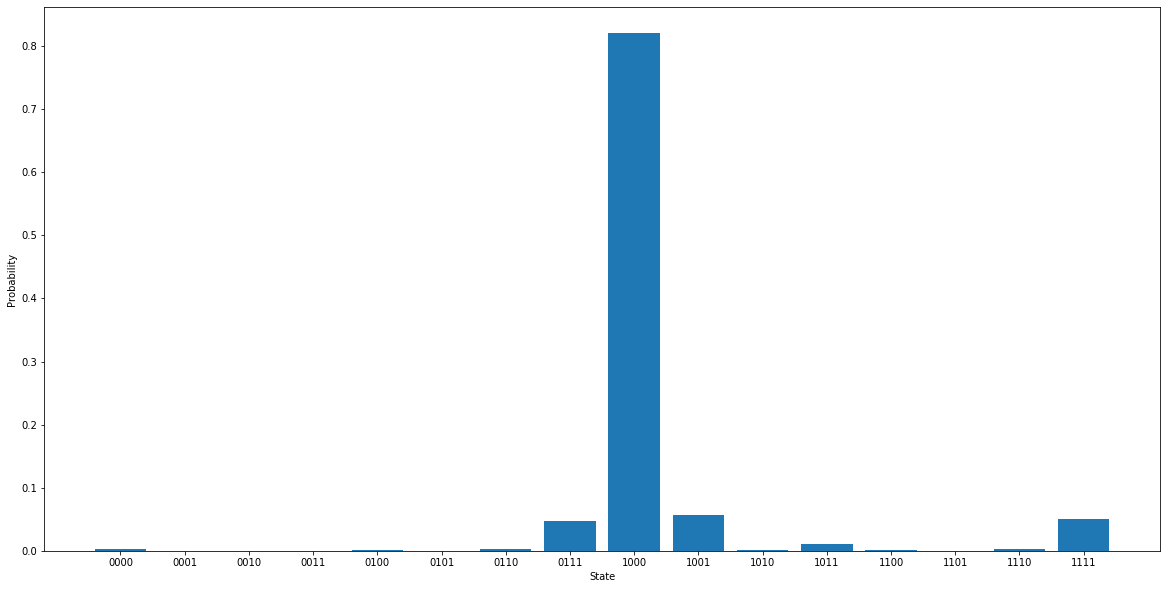

In [19]:
ising_QDP(-0.9, h, J, 1e-2)

====================REPORT====================
True result 3
new result:  2.998546520076842
Number of iteration:  2


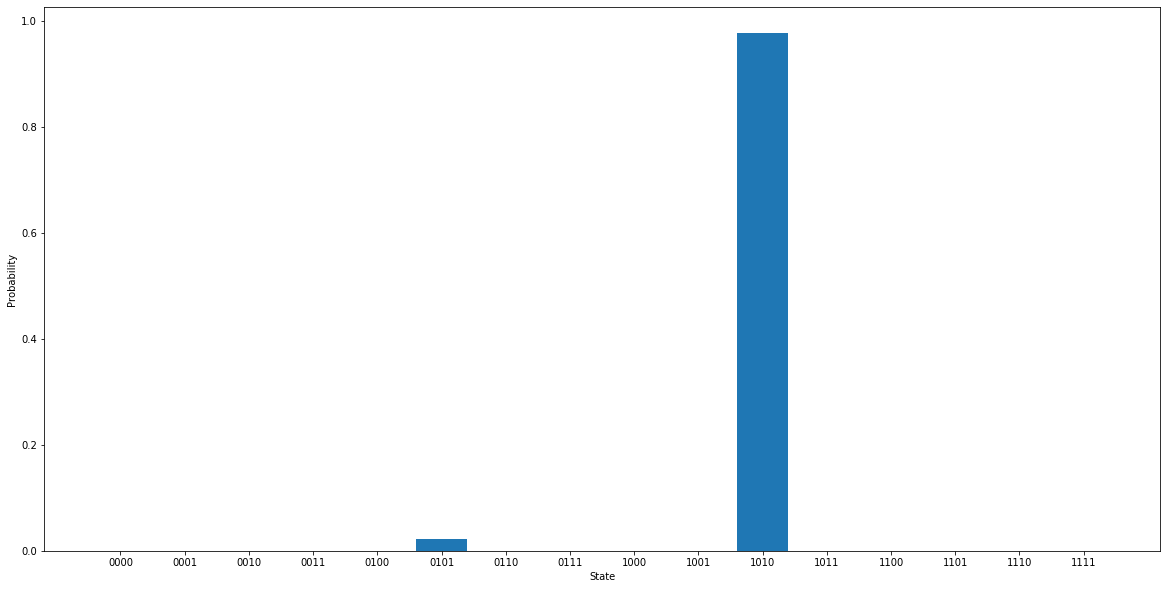

In [20]:
ising_QDP(3, h, J, 1e-2)

====================REPORT====================
True result -3.2
new result:  -3.1900759227867947
Number of iteration:  91


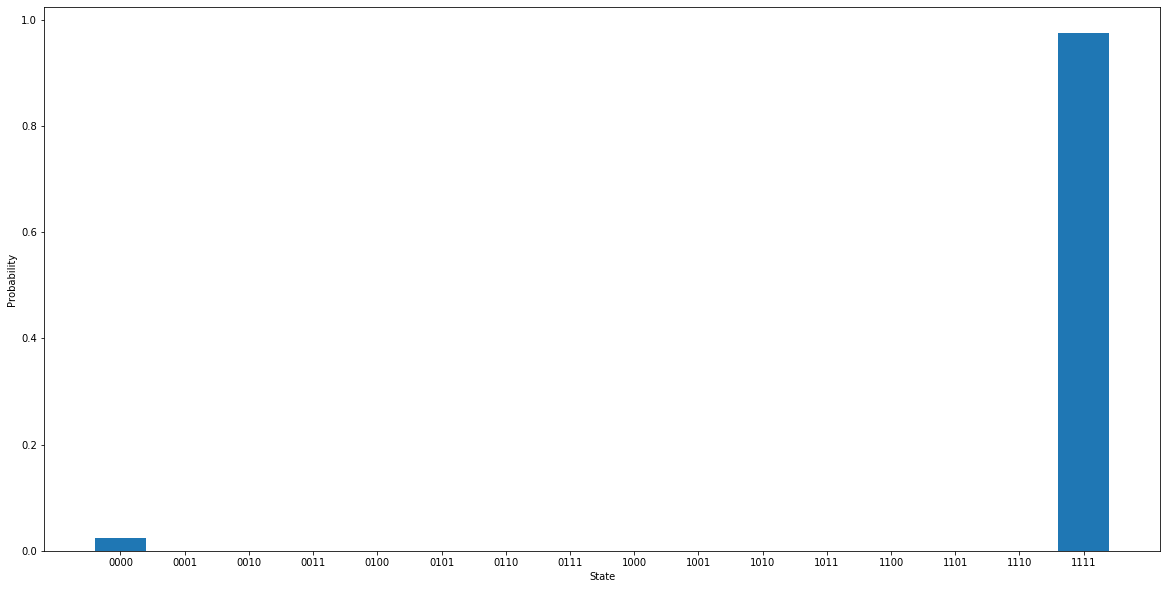

In [21]:
ising_QDP(-3.2, h, J, 1e-2)

In [25]:
qubit_num = 4
states = ["".join(seq) for seq in itertools.product("01", repeat=qubit_num)]
for state in states:
    print(energy(state, h, J), state)

-2.8 0000
-0.8999999999999999 0001
1.1 0010
-1.0 0011
1.0999999999999999 0100
3.0 0101
1.0 0110
-1.1 0111
-0.8999999999999999 1000
1.0 1001
3.0 1010
0.8999999999999999 1011
-1.0 1100
0.8999999999999999 1101
-1.0999999999999999 1110
-3.2 1111
